This notebook is supposed to be similar to the other analyze xgboost, but takes into account all gene importances, not just the top three and the last as in `analyze_xgboost_binary_gain.ipynb`

In [1]:
import pandas as pd
from glob import glob
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
from Bio import SeqIO
import os
import gzip
import numpy as np

from scipy.cluster.hierarchy import linkage, leaves_list

data = "920"
# max_assembly = 500
# min_samples = 3

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["figure.figsize"] = (5, 3)

path = '/pfs/work7/workspace/scratch/tu_kmpaj01-link'

/scratch/slurm_tmpdir/job_23847396/ipykernel_721336/2233221769.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
ip_names = pd.read_csv("https://ftp.ebi.ac.uk/pub/databases/interpro/current_release/entry.list",sep="\t",header=0)
ip_names.set_index("ENTRY_AC",inplace=True)

ip_names["ENTRY_NAME"] = ip_names["ENTRY_NAME"].str.replace("[","_").str.replace("]","_").str.replace("<","_")

rels =	[i.split("/")[-1].split(".")[0] for i in glob(f"{path}/xgboost/annotations{data}/*.pkl")]

### Read in the data

In [3]:
with open(f"{path}/xgboost/annotations{data}/binary/binary.pkl", 'rb') as f:
	d = pickle.load(f)

/pfs/data5/home/tu/tu_tu/tu_kmpaj01/miniforge3/envs/xgb/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:05:38] WARNING: /workspace/src/gbm/gbtree.cc:388: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/pfs/data5/home/tu/tu_tu/tu_kmpaj01/miniforge3/envs/xgb/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:05:38] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/pfs/data5/home/tu/tu_tu/tu_kmpaj01/miniforge3/envs/xgb/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:05:39] WARNING: /workspace/src/gbm/gbtree.cc:388: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/pfs/data5/home/tu/tu_tu/tu_kmpaj01/miniforge3/envs/xgb/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:05:39] WARNING: /workspace/src/context.cc:43: No visible GPU is found, se

In [4]:
l = []
for rel in tqdm(rels):
	for i in range(len(d[rel])):
		s = pd.Series(d[rel][i][2].get_score(importance_type="gain"))
		if len(s) > 0:
			importance_values = s.sort_values(ascending=False).values
			genes = s.sort_values(ascending=False).index.to_list()
			importance_ranking = s.sort_values(ascending=False).rank(ascending=False).values
			accuracy = d[rel][i][1]
			ner = d[rel][i][0][0]
			for j in range(len(importance_values)):
				l.append([rel, ner,genes[j], importance_values[j], importance_ranking[j],accuracy])


100%|██████████| 17/17 [00:04<00:00,  3.45it/s]


In [5]:
df = pd.DataFrame(l,columns=["rel","ner","gene","importance_values","importance_ranking","accuracy"])

In [6]:
df

,rel,ner,gene,importance_values,importance_ranking,accuracy
0,STRAIN-SPECIES:INHIBITS,e. coli,Protein of unknown function DUF2824,25.862751,1.0,0.946424
1,STRAIN-SPECIES:INHIBITS,e. coli,"Mannitol dehydrogenase, C-terminal",17.768427,2.0,0.946424
2,STRAIN-SPECIES:INHIBITS,e. coli,"Peptidase M15A, C-terminal",17.367559,3.0,0.946424
3,STRAIN-SPECIES:INHIBITS,e. coli,WD40 repeat,17.349373,4.0,0.946424
4,STRAIN-SPECIES:INHIBITS,e. coli,Holliday junction resolvase RusA-like,14.973459,5.0,0.946424
...,...,...,...,...,...,...
436377,STRAIN-DISEASE:ASSOCIATED_WITH,cystic fibrosis,Thioredoxin domain,0.054822,290.0,0.986674
436378,STRAIN-DISEASE:ASSOCIATED_WITH,cystic fibrosis,Thiaminase-2/PQQC,0.036651,291.0,0.986674
436379,STRAIN-DISEASE:ASSOCIATED_WITH,cystic fibrosis,"Thioredoxin 2, N-terminal domain",0.031480,292.0,0.986674
436380,STRAIN-DISEASE:ASSOCIATED_WITH,cystic fibrosis,Transglycosylase SLT domain 1,0.009236,293.0,0.986674


In [7]:
df[df["importance_ranking"]==1].value_counts("rel")

rel
STRAIN-MEDIUM:GROWS_ON            142
STRAIN-COMPOUND:PRODUCES          140
STRAIN-PHENOTYPE:PRESENTS          93
STRAIN-COMPOUND:RESISTS            79
STRAIN-ORGANISM:INFECTS            55
STRAIN-EFFECT:PRESENTS             50
STRAIN-ISOLATE:INHABITS            42
COMPOUND-STRAIN:INHIBITS           20
STRAIN-SPECIES:INHIBITS            17
STRAIN-ORGANISM:INHABITS           16
STRAIN-DISEASE:ASSOCIATED_WITH     10
STRAIN-EFFECT:PROMOTES              7
STRAIN-COMPOUND:DEGRADES            4
STRAIN-ORGANISM:INHIBITS            2
STRAIN-DISEASE:INHIBITS             1
STRAIN-ORGANISM:SYMBIONT_OF         1
Name: count, dtype: int64

In [8]:
df.sort_values("importance_values")

,rel,ner,gene,importance_values,importance_ranking,accuracy
399528,STRAIN-MEDIUM:GROWS_ON,5,"Conjugal transfer protein TrbD, putative",0.000002,754.0,0.998030
402623,STRAIN-MEDIUM:GROWS_ON,rcm,"NusG-like, N-terminal",0.000003,616.0,0.998333
387937,STRAIN-MEDIUM:GROWS_ON,lba,Phenazine biosynthesis protein A/B,0.000004,627.0,0.997878
152607,STRAIN-COMPOUND:PRODUCES,carbohydrate,MamQ/LemA,0.000005,560.0,0.998371
392489,STRAIN-MEDIUM:GROWS_ON,ypd,3D domain,0.000007,578.0,0.998080
...,...,...,...,...,...,...
305159,STRAIN-EFFECT:PROMOTES,of,Streptococcal surface-anchored protein repeat,172.957001,1.0,0.985834
308130,STRAIN-ORGANISM:INFECTS,mouse,OmpA-like domain,179.886475,1.0,0.937718
9348,STRAIN-ISOLATE:INHABITS,soil,"HTH-type transcriptional repressor KstR2, C-te...",236.979858,1.0,0.954361
40423,STRAIN-ORGANISM:INHABITS,human,"Competence protein, ComC",311.075867,1.0,0.931233


In [9]:
df[(df["ner"]!= "c")&(df["ner"]!= "l-")].sort_values("importance_values",ascending=False).to_csv("gene_importances.csv",index=False)

In [10]:
df[(df["rel"]== "STRAIN-ORGANISM:INFECTS")].sort_values("importance_values",ascending=False).to_csv("gene_importances_infects.csv",index=False)

### Host association

In [11]:
df

,rel,ner,gene,importance_values,importance_ranking,accuracy
0,STRAIN-SPECIES:INHIBITS,e. coli,Protein of unknown function DUF2824,25.862751,1.0,0.946424
1,STRAIN-SPECIES:INHIBITS,e. coli,"Mannitol dehydrogenase, C-terminal",17.768427,2.0,0.946424
2,STRAIN-SPECIES:INHIBITS,e. coli,"Peptidase M15A, C-terminal",17.367559,3.0,0.946424
3,STRAIN-SPECIES:INHIBITS,e. coli,WD40 repeat,17.349373,4.0,0.946424
4,STRAIN-SPECIES:INHIBITS,e. coli,Holliday junction resolvase RusA-like,14.973459,5.0,0.946424
...,...,...,...,...,...,...
436377,STRAIN-DISEASE:ASSOCIATED_WITH,cystic fibrosis,Thioredoxin domain,0.054822,290.0,0.986674
436378,STRAIN-DISEASE:ASSOCIATED_WITH,cystic fibrosis,Thiaminase-2/PQQC,0.036651,291.0,0.986674
436379,STRAIN-DISEASE:ASSOCIATED_WITH,cystic fibrosis,"Thioredoxin 2, N-terminal domain",0.031480,292.0,0.986674
436380,STRAIN-DISEASE:ASSOCIATED_WITH,cystic fibrosis,Transglycosylase SLT domain 1,0.009236,293.0,0.986674


In [12]:
oi = df[df["rel"]=="STRAIN-ORGANISM:INHABITS"]

In [13]:
common_genes = df.groupby("ner")["gene"].apply(set).reset_index()
common_genes = common_genes[common_genes["ner"].duplicated(keep=False)]


In [14]:
oi.ner.unique()

array(['human', 'mouse', 'chicken', 'plants', 'pig', 'tomato', 'rice',
       'pigs', 'poultry', 'cattle', 'wheat', 'potato', 'maize', 'plant',
       'sheep', 'dog'], dtype=object)

In [59]:
oi

,rel,ner,gene,importance_values,importance_ranking,accuracy
40423,STRAIN-ORGANISM:INHABITS,human,"Competence protein, ComC",311.075867,1.0,0.931233
40424,STRAIN-ORGANISM:INHABITS,human,"Domain of unknown function DUF3642, lipoprotein",162.746109,2.0,0.931233
40425,STRAIN-ORGANISM:INHABITS,human,"Conserved hypothetical CHP02185, integral memb...",57.144268,3.0,0.931233
40426,STRAIN-ORGANISM:INHABITS,human,RNA polymerase sigma-70 region 2,46.356205,4.0,0.931233
40427,STRAIN-ORGANISM:INHABITS,human,Short-chain dehydrogenase/reductase SDR,45.258472,5.0,0.931233
...,...,...,...,...,...,...
50497,STRAIN-ORGANISM:INHABITS,dog,Protein of unknown function DUF979,0.092927,498.0,0.990947
50498,STRAIN-ORGANISM:INHABITS,dog,"Ribonuclease B, N-terminal OB domain",0.090913,499.0,0.990947
50499,STRAIN-ORGANISM:INHABITS,dog,Putative pectate lyase-like adhesive domain,0.090506,500.0,0.990947
50500,STRAIN-ORGANISM:INHABITS,dog,"Transposase IS204/IS1001/IS1096/IS1165, helix-...",0.038606,501.0,0.990947


/scratch/slurm_tmpdir/job_23847396/ipykernel_721336/1067752636.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oiforheat["ner"] = oiforheat.ner.str.replace("pigs", "pig")


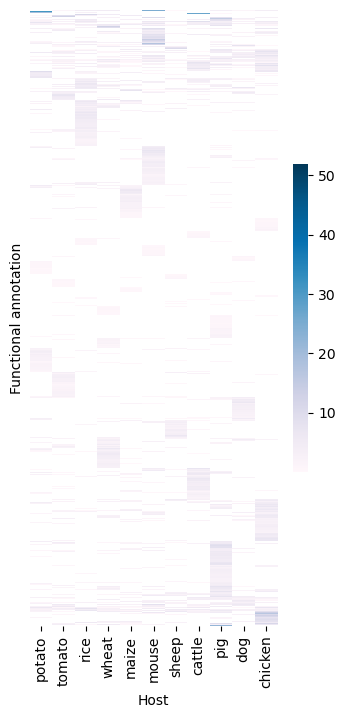

In [68]:
oiforheat = oi

oiforheat["ner"] = oiforheat.ner.str.replace("pigs", "pig")
# Remove non-informative ners and merge duplicated
to_filter_out = ["plants", "poultry", "plant","human"]
filtered_oi = oiforheat[~oiforheat['ner'].isin(to_filter_out)]

genes_occurrence = filtered_oi['gene'].value_counts()
genes_several = genes_occurrence.index.tolist()
filtered_oi = filtered_oi[filtered_oi['gene'].isin(genes_several)]

# Pivot the dataframe to create a matrix for the heatmap
heatmap_data = filtered_oi.pivot_table(index='ner', columns='gene', values='importance_values', aggfunc='max')

# Specify the order of organisms
#order_ner = ["potato", "tomato", "rice", "wheat", "maize"] #"mouse", "sheep", "cattle", "pig", "dog", "chicken"]
order_ner = ["potato", "tomato", "rice", "wheat", "maize","mouse","sheep", "cattle", "pig", "dog", "chicken"]
#order_ner = ["mouse","sheep","cattle","pig","dog","chicken"]

# Reorder heatmap_data to match the specified order of organisms
heatmap_data = heatmap_data.loc[order_ner]

# Clustering on genes
linkage_matrix = linkage(heatmap_data.T.fillna(0), method='average')
ordered_indices = leaves_list(linkage_matrix)
ordered_genes = heatmap_data.columns[ordered_indices]

# Reorder heatmap_data according to clustering of genes
heatmap_data = heatmap_data[ordered_genes]

# Create the heatmap
plt.figure(figsize=(4, 8))
sns.heatmap(heatmap_data.T, cmap='PuBu', annot=False, fmt=".2f", cbar=True, yticklabels=False, cbar_kws={'shrink': 0.5})

plt.xlabel('Host')
plt.ylabel('Functional annotation')
plt.savefig("figures/xgboost/xgboost_heatmap_cluster.pdf", bbox_inches="tight")

/scratch/slurm_tmpdir/job_23847396/ipykernel_721336/1331122923.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oiforheat["ner"] = oiforheat.ner.str.replace("pigs","pig")#.replace("zea mays","maize")


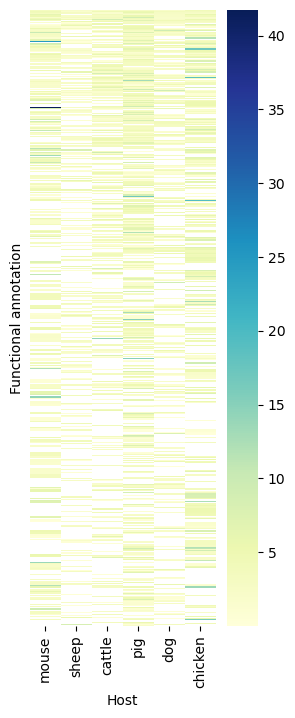

In [37]:
oiforheat = oi

oiforheat["ner"] = oiforheat.ner.str.replace("pigs","pig")#.replace("zea mays","maize")
#oiforheat["ner"] = oiforheat.ner.str.replace("arabidopsis thaliana","arabidopsis")
#oiforheat["ner"] = oiforheat.ner.str.replace("triticum","wheat")
# Remove non-informative ners and merge duplicated
to_filter_out = ["plants","poultry","plant","human"]# "cattle","mouse","sugarcane"]
filtered_oi = oiforheat[~oiforheat['ner'].isin(to_filter_out)]

genes_occurrence = filtered_oi['gene'].value_counts()
genes_several = genes_occurrence[genes_occurrence > 3].index.tolist()
filtered_oi = filtered_oi[filtered_oi['gene'].isin(genes_several)]

# Pivot the dataframe to create a matrix for the heatmap
heatmap_data = filtered_oi.pivot_table(index='ner', columns='gene', values='importance_values', aggfunc='max')

# order_ner = ["cattle","sheep","mouse","sugarcane","maize","wheat","rice","tobacco","tomato","potato","arabidopsis","soybean","phaseolus","medicago"]
# order_ner = ["potato","tomato","rice","wheat","maize"]#,"mouse","sheep","cattle","pig","dog","chicken"]
order_ner = ["mouse","sheep","cattle","pig","dog","chicken"]
#order_ner.reverse()
order_genes = [a for a in genes_occurrence.index.to_list() if a in heatmap_data.columns.to_list()]

heatmap_data = heatmap_data.loc[order_ner,order_genes]
# Create the heatmap
plt.figure(figsize=(3, 8))
sns.heatmap(heatmap_data.T, cmap='YlGnBu', annot=False, fmt=".2f", cbar=True, yticklabels=False)

#plt.title('Importance Values Heatmap')
plt.xlabel('Host')
plt.ylabel('Functional annotation')
plt.savefig("figures/xgboost/xgboost_heatmap.pdf",bbox_inches="tight")

In [51]:
heatmap_data.dropna(axis=1,how="any")

gene,"Integrase, catalytic domain",Transposase IS4-like domain
ner,,
potato,1.356208,1.851485
tomato,1.808120,1.979015
rice,5.923912,1.426734
wheat,3.029648,2.578198
maize,2.395079,0.322287
mouse,4.280241,3.308727
human,11.316908,5.890079
sheep,1.666665,2.056479
cattle,4.686127,2.561764


/scratch/slurm_tmpdir/job_23847396/ipykernel_721336/1941254114.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.clustermap(heatmap_data.fillna(0).applymap(lambda x: 1 if x != 0 else 0),figsize=(10,10))


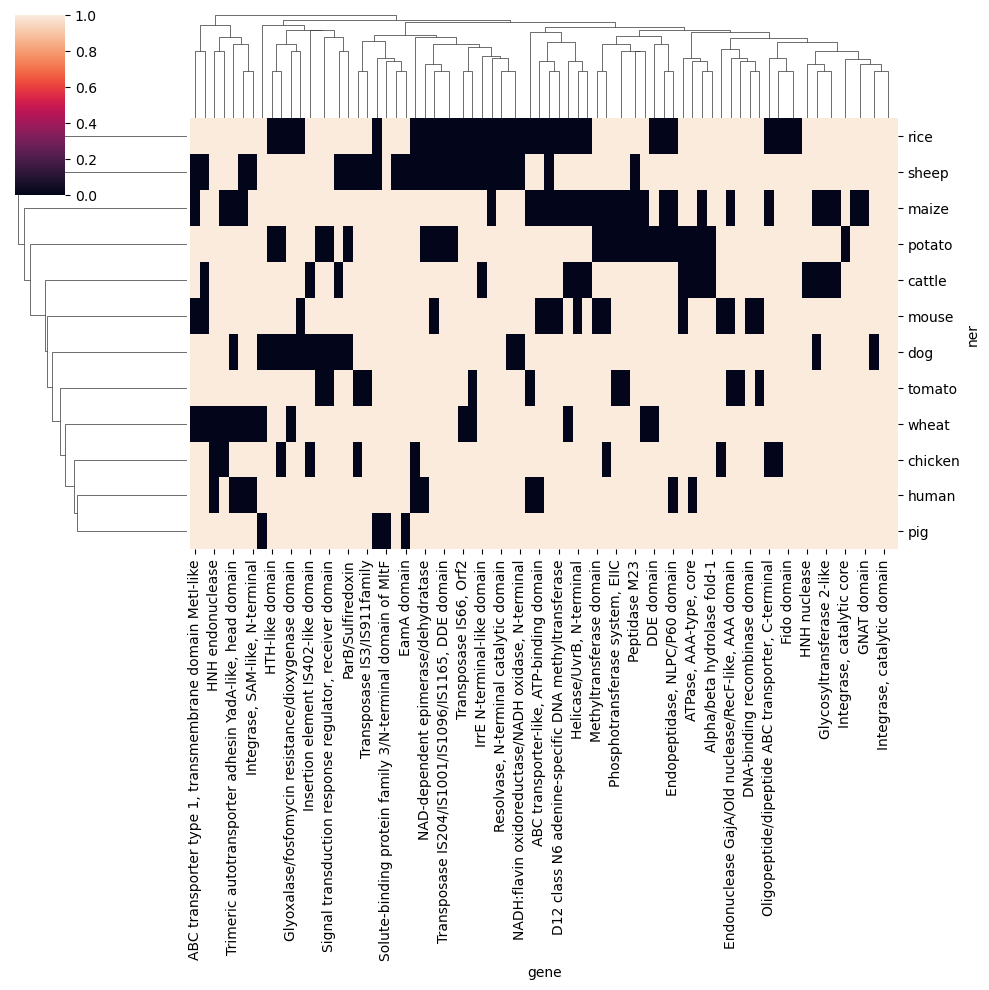

In [57]:
sns.clustermap(heatmap_data.fillna(0).applymap(lambda x: 1 if x != 0 else 0),figsize=(10,10))

#### Check for evolution on these genes

In [69]:
genes_to_check = heatmap_data.T.index

### Phenotypic traits

---

In [70]:
df

,rel,ner,gene,importance_values,importance_ranking,accuracy
0,STRAIN-SPECIES:INHIBITS,e. coli,Protein of unknown function DUF2824,25.862751,1.0,0.946424
1,STRAIN-SPECIES:INHIBITS,e. coli,"Mannitol dehydrogenase, C-terminal",17.768427,2.0,0.946424
2,STRAIN-SPECIES:INHIBITS,e. coli,"Peptidase M15A, C-terminal",17.367559,3.0,0.946424
3,STRAIN-SPECIES:INHIBITS,e. coli,WD40 repeat,17.349373,4.0,0.946424
4,STRAIN-SPECIES:INHIBITS,e. coli,Holliday junction resolvase RusA-like,14.973459,5.0,0.946424
...,...,...,...,...,...,...
436377,STRAIN-DISEASE:ASSOCIATED_WITH,cystic fibrosis,Thioredoxin domain,0.054822,290.0,0.986674
436378,STRAIN-DISEASE:ASSOCIATED_WITH,cystic fibrosis,Thiaminase-2/PQQC,0.036651,291.0,0.986674
436379,STRAIN-DISEASE:ASSOCIATED_WITH,cystic fibrosis,"Thioredoxin 2, N-terminal domain",0.031480,292.0,0.986674
436380,STRAIN-DISEASE:ASSOCIATED_WITH,cystic fibrosis,Transglycosylase SLT domain 1,0.009236,293.0,0.986674


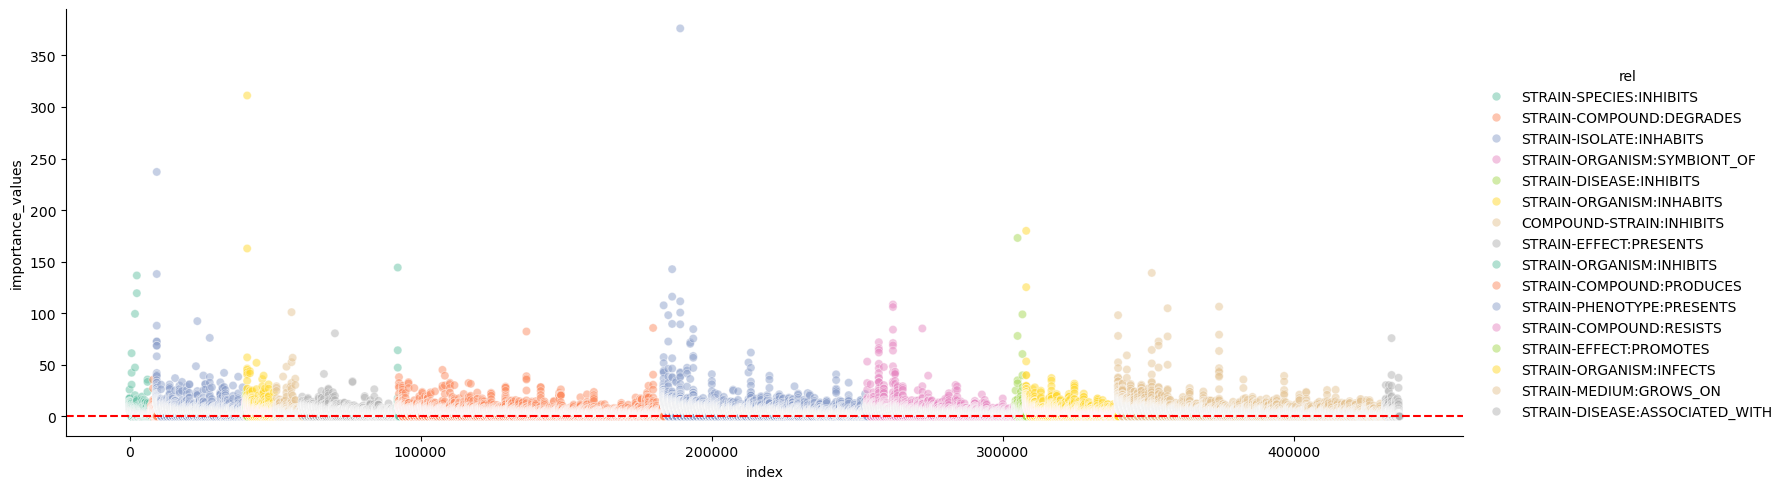

In [71]:
sns.relplot(y="importance_values", x="index", hue="rel", data=df.reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.37, color='r', linestyle='--')

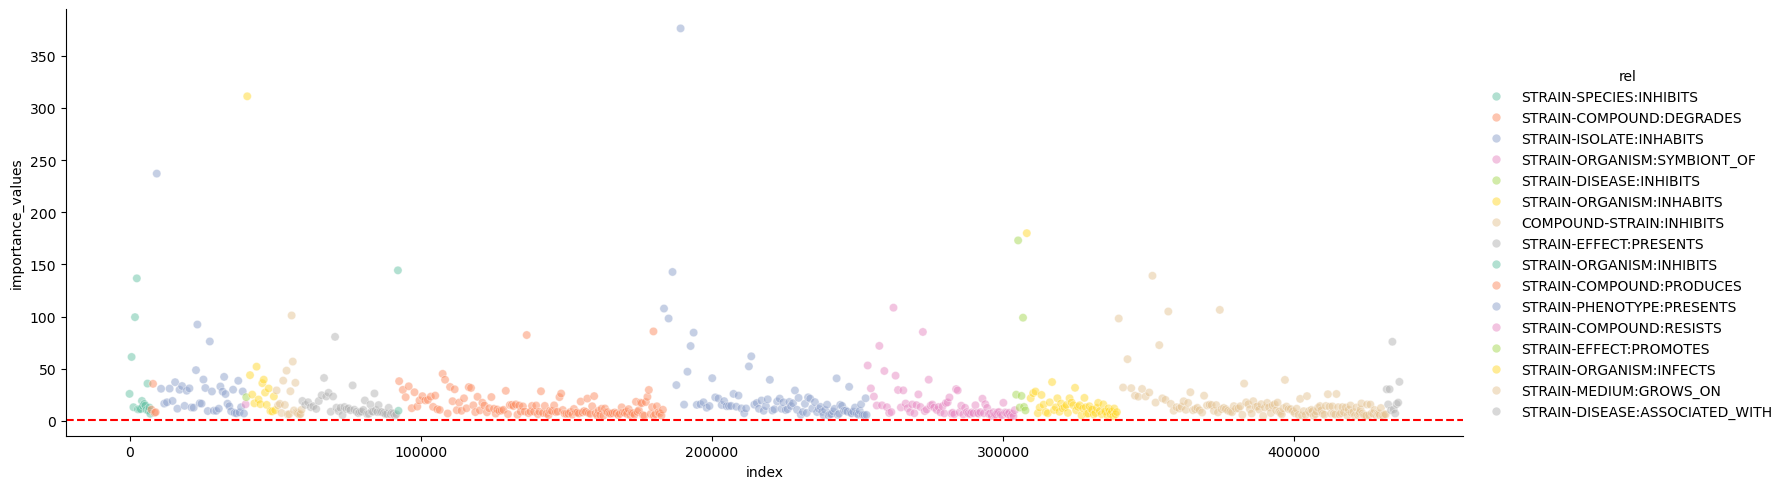

In [72]:
sns.relplot(y="importance_values", x="index", hue="rel", data=df[df["importance_ranking"]==1].reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.37, color='r', linestyle='--')

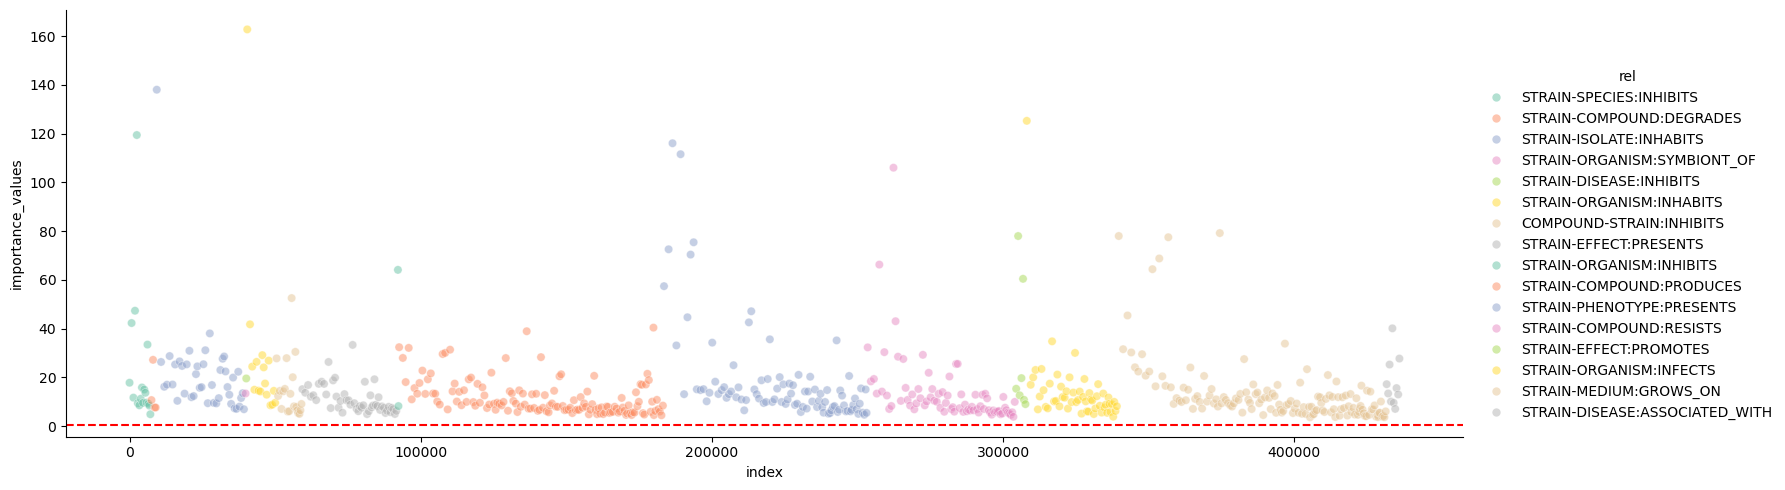

In [73]:
sns.relplot(y="importance_values", x="index", hue="rel", data=df[df["importance_ranking"]==2].reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.37, color='r', linestyle='--')

add value counts and check whether these play a role in the value significance. if it does, we could consider normalizing by this value

In [74]:
df

,rel,ner,gene,importance_values,importance_ranking,accuracy
0,STRAIN-SPECIES:INHIBITS,e. coli,Protein of unknown function DUF2824,25.862751,1.0,0.946424
1,STRAIN-SPECIES:INHIBITS,e. coli,"Mannitol dehydrogenase, C-terminal",17.768427,2.0,0.946424
2,STRAIN-SPECIES:INHIBITS,e. coli,"Peptidase M15A, C-terminal",17.367559,3.0,0.946424
3,STRAIN-SPECIES:INHIBITS,e. coli,WD40 repeat,17.349373,4.0,0.946424
4,STRAIN-SPECIES:INHIBITS,e. coli,Holliday junction resolvase RusA-like,14.973459,5.0,0.946424
...,...,...,...,...,...,...
436377,STRAIN-DISEASE:ASSOCIATED_WITH,cystic fibrosis,Thioredoxin domain,0.054822,290.0,0.986674
436378,STRAIN-DISEASE:ASSOCIATED_WITH,cystic fibrosis,Thiaminase-2/PQQC,0.036651,291.0,0.986674
436379,STRAIN-DISEASE:ASSOCIATED_WITH,cystic fibrosis,"Thioredoxin 2, N-terminal domain",0.031480,292.0,0.986674
436380,STRAIN-DISEASE:ASSOCIATED_WITH,cystic fibrosis,Transglycosylase SLT domain 1,0.009236,293.0,0.986674


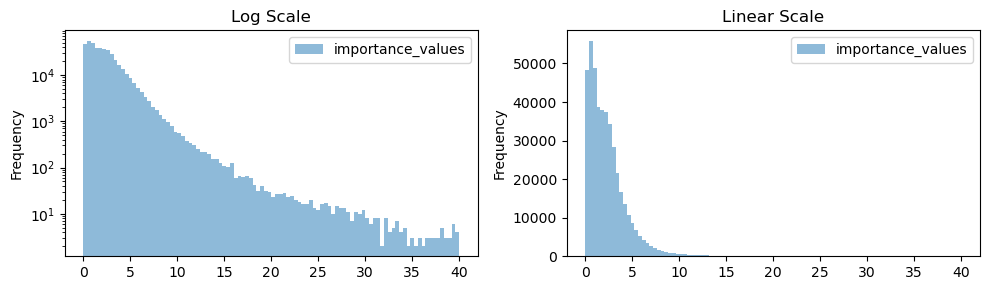

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
df.plot(kind='hist',y="importance_values",bins=100,range=(0,40),alpha=0.5, ax=ax[0])
df.plot(kind='hist',y="importance_values",bins=100,range=(0,40),alpha=0.5, ax=ax[1])
ax[0].set_yscale("log")
ax[0].set_title('Log Scale')
ax[1].set_title('Linear Scale')
plt.tight_layout()


#### Group by function

In [76]:
df.value_counts("gene")

gene
Integrase, catalytic core                    667
Transposase IS4-like domain                  637
Transposase IS3/IS911family                  622
HTH-like domain                              619
Resolvase, N-terminal catalytic domain       612
                                            ... 
Fis1, C-terminal tetratricopeptide repeat      1
Fimbrillin-like                                1
Fimbrial adhesin F17-AG, lectin domain         1
DNA/RNA-binding protein Alba-like              1
Protein of unknown function DUF3155            1
Name: count, Length: 10819, dtype: int64

In [77]:
df[df["gene"]=="Integrase, catalytic core"]

,rel,ner,gene,importance_values,importance_ranking,accuracy
340,STRAIN-SPECIES:INHIBITS,e. coli,"Integrase, catalytic core",3.717520,341.0,0.946424
1187,STRAIN-SPECIES:INHIBITS,s. aureus,"Integrase, catalytic core",1.459195,482.0,0.960401
1607,STRAIN-SPECIES:INHIBITS,staphylococcus aureus,"Integrase, catalytic core",2.473056,273.0,0.969252
2134,STRAIN-SPECIES:INHIBITS,p. aeruginosa,"Integrase, catalytic core",2.233790,261.0,0.966224
2728,STRAIN-SPECIES:INHIBITS,c. albicans,"Integrase, catalytic core",1.384699,230.0,0.983461
...,...,...,...,...,...,...
434472,STRAIN-DISEASE:ASSOCIATED_WITH,bacteremia,"Integrase, catalytic core",1.316249,358.0,0.979603
435002,STRAIN-DISEASE:ASSOCIATED_WITH,infection,"Integrase, catalytic core",1.199624,358.0,0.981779
435293,STRAIN-DISEASE:ASSOCIATED_WITH,diarrhea,"Integrase, catalytic core",2.424748,188.0,0.984226
435900,STRAIN-DISEASE:ASSOCIATED_WITH,outbreak,"Integrase, catalytic core",1.754113,228.0,0.984498


#### Calculate number of assemblies per NER

TODO: Calculate also species per NER?

In [ ]:
assemblies_perner = []
for rel in tqdm(rels):
	d[rel]= []
	filepath = f"{path}/xgboost/annotations{data}/{rel}.pkl"
	# Read the pickle file
	with open(filepath, "rb") as f:
		dat = pickle.load(f)
	vc = pd.DataFrame(pd.DataFrame(dat[1]).value_counts())
	vc["rel"] = rel
	assemblies_perner.append(vc)
	

 59%|█████▉    | 10/17 [01:08<01:30, 12.93s/it]

In [ ]:
assemblies = pd.concat(assemblies_perner)

In [ ]:
merged_df = df.merge(assemblies,left_on=["rel","ner"],right_on=["rel",0])

In [ ]:
merged_df.sort_values("count")

/tmp/ipykernel_90974/963669256.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(y="importance_values", x="count", col="rel", data=merged_df,aspect=2, height=2, palette="Set2",col_wrap=5, alpha=.5)


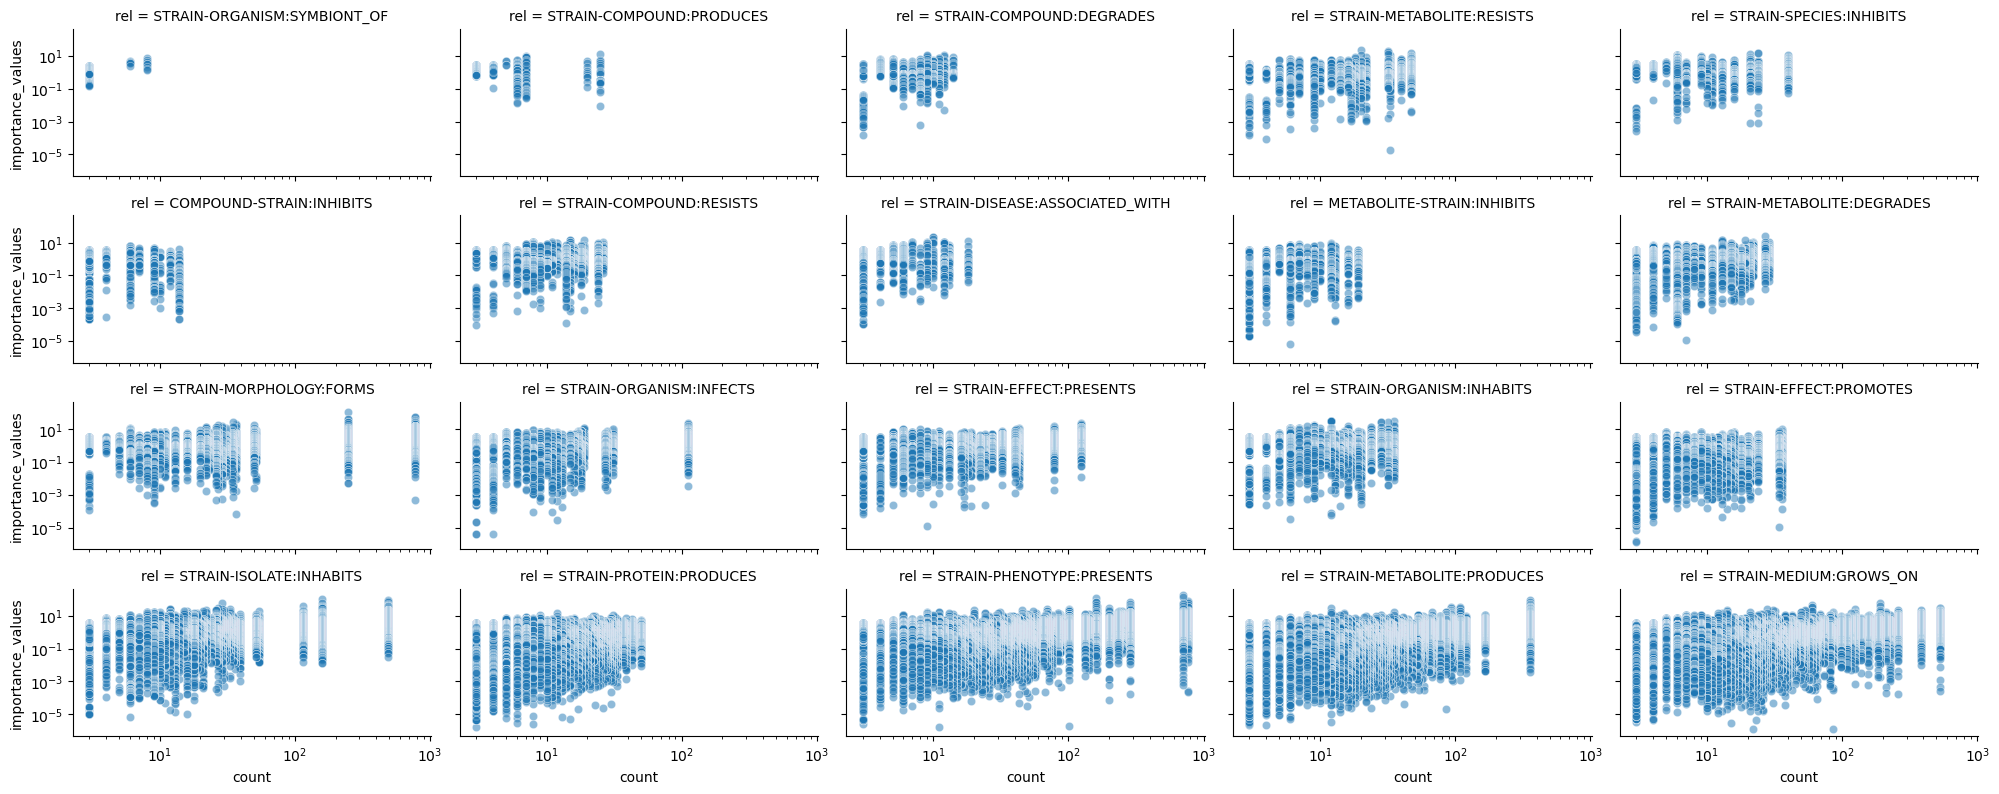

In [47]:
sns.relplot(y="importance_values", x="count", col="rel", data=merged_df,aspect=2, height=2, palette="Set2",col_wrap=5, alpha=.5)
plt.xscale("log")
plt.yscale("log")

#### Try to normalize by the number of assemblies per NER

In [49]:
merged_df['normalized_value'] = (merged_df['importance_values'] / merged_df['count'])

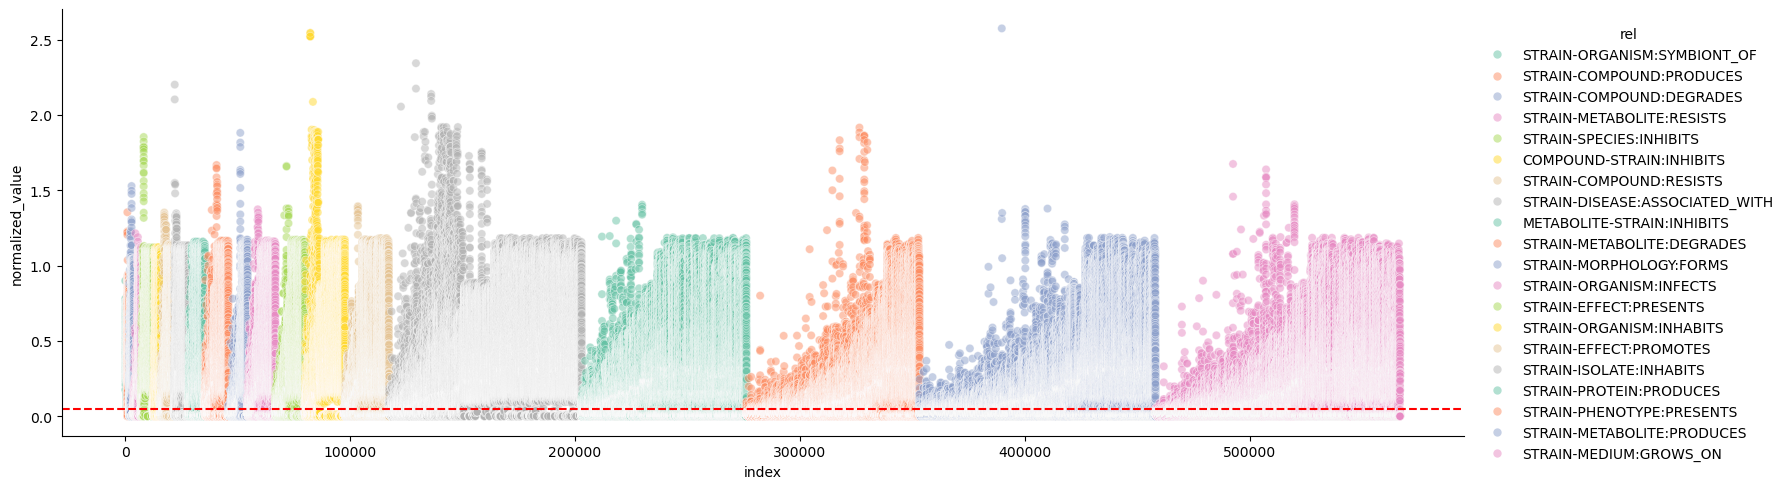

In [50]:
sns.relplot(y="normalized_value", x="index", hue="rel", data=merged_df.reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.05, color='r', linestyle='--')

In [51]:
merged_df.sort_values("normalized_value")

,rel,ner,gene,importance_values,importance_ranking,accuracy,count,normalized_value
466820,STRAIN-MEDIUM:GROWS_ON,mrs broth,Translational (tr)-type GTP-binding domain,0.000001,368.0,0.994526,86,1.396442e-08
284953,STRAIN-PHENOTYPE:PRESENTS,nitrogen-fixing,"Sulphur relay, TusB/DsrH",0.000002,457.0,0.989985,101,1.895841e-08
484805,STRAIN-MEDIUM:GROWS_ON,nutrient,6-carboxyhexanoate--CoA ligase,0.000001,180.0,0.998390,22,5.436331e-08
314587,STRAIN-PHENOTYPE:PRESENTS,methane-oxidizing,PAS fold-4,0.000002,58.0,0.999148,11,1.527369e-07
492235,STRAIN-MEDIUM:GROWS_ON,king's medium b,"DNA binding HTH domain, AraC-type",0.000003,144.0,0.998551,15,1.874597e-07
...,...,...,...,...,...,...,...,...
82165,STRAIN-ORGANISM:INHABITS,soybean plant,"Transposase TnpC, homeodomain",30.249023,1.0,0.997567,12,2.520752e+00
82245,STRAIN-ORGANISM:INHABITS,casuarina,Pterin 4 alpha carbinolamine dehydratase,30.249023,1.0,0.996350,12,2.520752e+00
82251,STRAIN-ORGANISM:INHABITS,p. larvae,ADP ribosyltransferase,30.517075,2.0,1.000000,12,2.543090e+00
82250,STRAIN-ORGANISM:INHABITS,p. larvae,"L-tyrosine decarboxylase, C-terminal",30.530426,1.0,1.000000,12,2.544202e+00


#### Find features where top three are very close

## Evolution

### Example (do not run)

In [57]:
merged_df.iloc[485]

rel                                  STRAIN-PHENOTYPE:PRESENTS
ner                                     plant growth-promoting
first_value                                           2.934033
first_gene                             Pyocin S killer protein
second_value                                          2.929163
second_gene                      Ribosome-inactivating protein
third_value                                           2.928898
third_gene                 Protein of unknown function DUF3275
count                                                       10
normalized_value                                      0.293403
first_second_difference                               0.004871
first_third_difference                                0.005135
Name: 485, dtype: object

In [58]:
parq = pd.read_parquet(f"/home/gomez/gomez/xgboost/annotations810_7/{merged_df.iloc[485].rel}.parquet")

In [59]:
strains = parq[parq["word_qc"]==merged_df.iloc[485].ner].sa_ner.str.split("_",expand=True)[0].unique()

In [60]:
protein_ids = parq[parq["InterPro_description"]== merged_df.iloc[485].first_gene].Protein_accession.unique()

In [61]:

output_faa = []
for s in strains:
	strain = s.replace(" ","_")
	# Check if the folder exists
	folder_path = f"/home/gomez/gomez/assemblies_linkbert_5/{strain}"
	if os.path.exists(folder_path):
		for assembly in os.listdir(folder_path):
			faa_files = glob(f"{folder_path}/{assembly}/*.faa")
			if faa_files:
				faa_file = faa_files[0]
				for record in SeqIO.parse(faa_file, "fasta"):
					if record.id in protein_ids:
						output_faa.append(record)

with open("test.faa","w") as f:
	SeqIO.write(output_faa, f, "fasta")

In [64]:
output_fna = []
for s in strains:
	strain = s.replace(" ","_")
	folder_path = f"/home/gomez/gomez/assemblies_linkbert_5/{strain}"
	if os.path.exists(folder_path):
		for assembly in os.listdir(folder_path):
			fna_files = glob(f"{folder_path}/{assembly}/*.fasta")
			if fna_files:
				fna_file = fna_files[0]
				for record in SeqIO.parse(fna_file, "fasta"):
					if record.id in protein_ids:
						output_fna.append(record)
with open("test.fna","w") as f:
	SeqIO.write(output_fna, f, "fasta")

### Run for all rows in merged_df and save files into a folder each

In [28]:
outdir = f"/home/gomez/gomez/seqfiles_linkbert_{data}_{max_assembly}"
os.makedirs(outdir,exist_ok=True)
for rel in tqdm(merged_df['rel'].unique()):
	filtered_df = merged_df[merged_df['rel'] == rel]
	parq = pd.read_parquet(f"/home/gomez/gomez/xgboost/annotations810_7/{rel}.parquet")
	for row in tqdm(filtered_df.iterrows(), total=len(filtered_df), leave=False):
		sa_ner = parq[parq["word_qc"]==row[1]['ner']].sa_ner
		if not sa_ner.empty:  # Use .empty to check if the Series is empty
			strains = sa_ner.str.split("_",expand=True)[0].unique()
			new_rel = row[1]['rel'].replace(':','_')
			new_ner = row[1]['ner'].replace(' ','_').replace("'",'').replace('(','_').replace(')','_')
			sa_ner = f"first_{new_rel}_{new_ner}"
			protein_ids = parq[parq["InterPro_description"]== row[1]['first_gene']].Protein_accession.unique()
			output_faa = []
			output_fna = []
			for s in strains:
				strain = s.replace(" ","_")
				folder_path = f"/home/gomez/gomez/assemblies_linkbert_5/{strain}"
				if os.path.exists(folder_path):
					for assembly in os.listdir(folder_path):
						faa_files = glob(f"{folder_path}/{assembly}/*.faa")
						fna_files = glob(f"{folder_path}/{assembly}/*.fasta")
						if faa_files:
							faa_file = faa_files[0]
							for record in SeqIO.parse(faa_file, "fasta"):
								if record.id in protein_ids:
									record.description = ""
									output_faa.append(record)
						if fna_files:
							fna_file = fna_files[0]
							for record in SeqIO.parse(fna_file, "fasta"):
								if record.id in protein_ids:
									output_fna.append(record)
			os.makedirs(f"{outdir}/{sa_ner}",exist_ok=True)
			with open(f"{outdir}/{sa_ner}/seq.faa","w") as f:
				SeqIO.write(output_faa, f, "fasta")
			with open(f"{outdir}/{sa_ner}/seq.fna","w") as f:
				SeqIO.write(output_fna, f, "fasta")

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

### Create test set

In [29]:
# outdir = f"/home/gomez/gomez/seqfiles_linkbert_{data}_{max_assembly}"
# os.makedirs(outdir,exist_ok=True)
for rel in tqdm(merged_df['rel'].unique()):
	filtered_df = merged_df[merged_df['rel'] == rel]
	parq = pd.read_parquet(f"/home/gomez/gomez/xgboost/annotations810_7/{rel}.parquet")
	for row in tqdm(filtered_df.iterrows(), total=len(filtered_df), leave=False):
		sa_ner = parq[parq["word_qc"]==row[1]['ner']].sa_ner
		if not sa_ner.empty:  # Use .empty to check if the Series is empty
			strains = sa_ner.str.split("_",expand=True)[0].unique()
			new_rel = row[1]['rel'].replace(':','_')
			new_ner = row[1]['ner'].replace(' ','_').replace("'",'').replace('(','_').replace(')','_')
			sa_ner = f"last_{new_rel}_{new_ner}"
			protein_ids = parq[parq["InterPro_description"]== row[1]['last_gene']].Protein_accession.unique()
			output_faa = []
			output_fna = []
			for s in strains:
				strain = s.replace(" ","_")
				folder_path = f"/home/gomez/gomez/assemblies_linkbert_5/{strain}"
				if os.path.exists(folder_path):
					for assembly in os.listdir(folder_path):
						faa_files = glob(f"{folder_path}/{assembly}/*.faa")
						fna_files = glob(f"{folder_path}/{assembly}/*.fasta")
						if faa_files:
							faa_file = faa_files[0]
							for record in SeqIO.parse(faa_file, "fasta"):
								if record.id in protein_ids:
									record.description = ""
									output_faa.append(record)
						if fna_files:
							fna_file = fna_files[0]
							for record in SeqIO.parse(fna_file, "fasta"):
								if record.id in protein_ids:
									output_fna.append(record)
			os.makedirs(f"{outdir}/{sa_ner}",exist_ok=True)
			with open(f"{outdir}/{sa_ner}/seq.faa","w") as f:
				SeqIO.write(output_faa, f, "fasta")
			with open(f"{outdir}/{sa_ner}/seq.fna","w") as f:
				SeqIO.write(output_fna, f, "fasta")

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

In [30]:

# Set the directory where the files are located
directory = "/home/gomez/gomez/seqfiles_linkbert_810_5"

# Iterate over all files in the directory
for root, dirs, files in tqdm(os.walk(directory)):
    for file in files:
        # Check if the file is a fasta file
        if file.endswith(".faa") or file.endswith(".fna"):
            # Get the full path of the file
            file_path = os.path.join(root, file)
            
            # Create a temporary file to store the deduplicated sequences
            temp_file = file_path + ".temp"
            
            # Run seqkit rmdup command to delete duplicate sequences
            os.system(f"seqkit rmdup -n -o {temp_file} {file_path}")
            
            # Replace the original file with the deduplicated file
            os.replace(temp_file, file_path)


0it [00:00, ?it/s]

[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records 